In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
import json, shutil, random
from tqdm import tqdm
from datetime import datetime
from omegaconf import OmegaConf
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from PIL import Image, ImageDraw
import torch
lt.monkey_patch()

sys.path.append("../../src")
from musubi_tuner.fpack_1fmc_generate import FramePack_1fmc
from musubi_tuner.frame_pack.hunyuan_video_packed import attn_cache
from musubi_tuner.utils.preproc_utils import getres, get_info_from_vistorybench, parse_bodylayout
from musubi_tuner.utils.viz_utils import convert_result_to_df_wpose, annot_viz, draw_final_img
from musubi_tuner.utils.attn_utils import get_img_attn_map

sys.path.append("/home/yo564250/workspace/whisperer/datasets/storyviz/vistorybench")
# sys.path.append("/projects/bffz/ykwon4/vistorybench/")
from vistorybench.data_process.dataset_process.dataset_load import StoryDataset
vistory_dataset_path = Path("/groups/chenchen/patrick/ViStoryBench/dataset/ViStory")
# vistory_dataset_path = Path("/projects/bffz/ykwon4/vistorybench/data/dataset/ViStory")
vistory_dataset = StoryDataset(vistory_dataset_path)

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:root:Xformers is installed!
INFO:root:Flash Attn is installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention
model_path is /lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/ckpts/hr16/yolox-onnx/yolox_l.torchscript.pt
model_path is /lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/ckpts/hr16/DWPose-TorchScript-BatchSize5/dw-ll_ucoco_384_bs5.torchscript.pt

DWPose: Using yolox_l.torchscript.pt for bbox detection and dw-ll_ucoco_384_bs5.torchscript.pt for pose estimation
DWPose: Caching TorchScript module yolox_l.torchscript.pt on ...
DWPose: Caching TorchScript module dw-ll_ucoco_384_bs5.torchscript.pt on ...


/home/yo564250/conda-envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yo564250/conda-envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cuda:0


In [2]:
# framepack_model = FramePack_1fmc(
#     dit_path = "/projects/bffz/ykwon4/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors",
#     vae_path = "/projects/bffz/ykwon4/ComfyUI/models/vae/hunyuan-video-t2v-720p-vae.pt",
#     text_encoder1_path = "/projects/bffz/ykwon4/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors",
#     text_encoder2_path = "/projects/bffz/ykwon4/ComfyUI/models/text_encoders/clip_l.safetensors",
#     lora_path = "/work/nvme/bffz/ykwon4/musubi-training/idmask_control_lora_wrope_v3/idmask_control_lora_wrope_v3-3-step00003000.safetensors"
# )
framepack_model = FramePack_1fmc(
    lora_path = "/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/outputs/training/idmask_control_lora_wrope_v3/idmask_control_lora_wrope_v3_multi-1-step00003000.safetensors"
)

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda:0
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from /home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/outputs/training/idmask_control_lora_wrope_v3/idmask_control_lora_wrope_v3_multi-1-step00003000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.l

Model, VAE, Text Encoders, LoRA loaded.


### ViStoryBench

Illustration, Ancient Chinese Legends;Medium close up, eye level shot;Niulang holds Zhinü's fairy garments, looking awkward. Zhinü stands before him, covering herself with her hands, her expression shy, with a hint of resignation in her eyes;Evening, by the Milky Way, tense and awkward, rippling waters of the Milky Way, Zhinü's fairy garments scattered on the shore, distant stars twinkling;Niulang did as told, and Zhinü, unable to leave without her garments, agreed to marry him.
[[0.666, 0.24, 0.924, 0.971], [0.055, 0.295, 0.372, 0.984]]
["Niulang (Cowherd) : ['/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/61/image/Niulang (Cowherd)/00.jpg']", "Zhinü (Weaving Maiden) : ['/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/61/image/Zhinü (Weaving Maiden)/00.jpg', '/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/61/image/Zhinü (Weaving Maiden)/01.jpg', '/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/61/image/Zhinü (Weaving Maiden)/02.jpg']"]


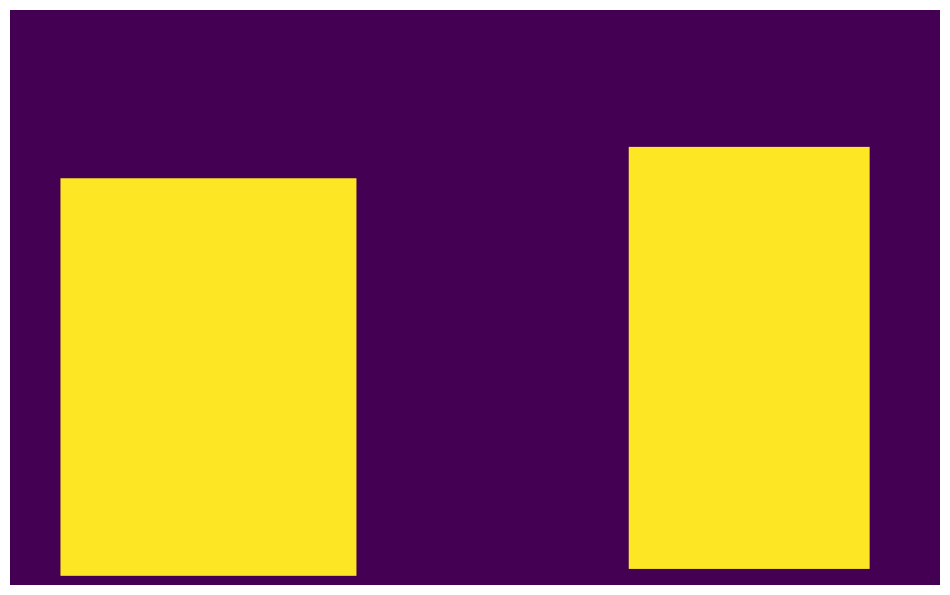

In [3]:
# main_layout_path = Path("/projects/bffz/ykwon4/vistorybench/data/gen_layouts_bulk/20250927_101053")
main_layout_path = Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20250927_101053")
story_num = '61'
shot_num = 5

story = vistory_dataset.load_story(story_num)
story_dict = {x['index']:x for x in story['shots']}
vanila_shot, vanila_character_shot, _ = get_info_from_vistorybench(vistory_dataset, story_num, 1)

shot_num = int(shot_num)
story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
prompt = ";".join(prompt.split(";")[:5])
# for k,v in characters_shot.items():
#     v['images'] = [x.replace('image', 'image_crop') for x in v['images']]

layouts = [
    (x.stem, list(map(int, x.stem.split("-pages_")[-1].split("_")))) 
    for x in  list(main_layout_path.glob(f"story_{story_num}*"))]
layout_name = [(x[0], x[1][0]) for x in layouts if shot_num in range(x[1][0], x[1][1]+1)][0]
author_output_dir = main_layout_path / layout_name[0]

layout = parse_bodylayout(author_output_dir / "pose_layout.json")
panel_bbox, panel_layout = layout[f'[PANEL-{shot_num-layout_name[1]+1}]']
panel_width, panel_height = (panel_bbox[2]-panel_bbox[0])/1000*768, (panel_bbox[3]-panel_bbox[1])/1000*1024
width, height = getres(panel_width, panel_height, 
    target_area=1280*720, max_aspect_ratio=2.5)
# panel_layout = {0 : {'bbox': [0.9, 0.1, 1.0, 0.2]}}
# panel_layout = {0 : {'bbox': [0.4, 0.1, 0.7, 0.9], 'body': []}}
# panel_layout = {1: {'bbox': [0.037, 0.266, 0.34, 0.938], 'body' : []}, 0 : {'bbox':[0.378, 0.1, 0.9, 0.9], 'body' : {}}}
# width, height = 1280, 720

print(prompt)
print([v['bbox'] for _, v in panel_layout.items()])
print([f"{k} : {v['images']}" for k, v in characters_shot.items()])

mask = Image.new("L", (width, height), 0)
draw = ImageDraw.Draw(mask)
for key, value in panel_layout.items():
    x0, y0, x1, y1 = value['bbox']
    x0, y0, x1, y1 = int(x0*width), int(y0*height), int(x1*width), int(y1*height)
    draw.rectangle([x0, y0, x1, y1], fill=255, width=3)
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.imshow(np.asarray(mask).astype(np.uint8), cmap='viridis')
ax.axis("off")
plt.show()

# prev_output_path = Path("/groups/chenchen/patrick/ViStoryBench/outputs/whisperer/v3_3_step6000/en/20251028_232847")
# shutil.copytree(prev_output_path / story_num, f"tmp/{story_num}", dirs_exist_ok=True)

  0%|          | 0/25 [00:00<?, ?it/s]

/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/frame_pack/hunyuan_video_packed.py:802: UserWarning: You are using Attention Mask, but sageattn does not support attention masking. Moving to normal SDPA
  warnings.warn(f"You are using Attention Mask, but {attn_mode} does not support attention masking. Moving to normal SDPA")
/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/utils/viz_utils.py:192: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/utils/viz_utils.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.savefig(buf, format='png')


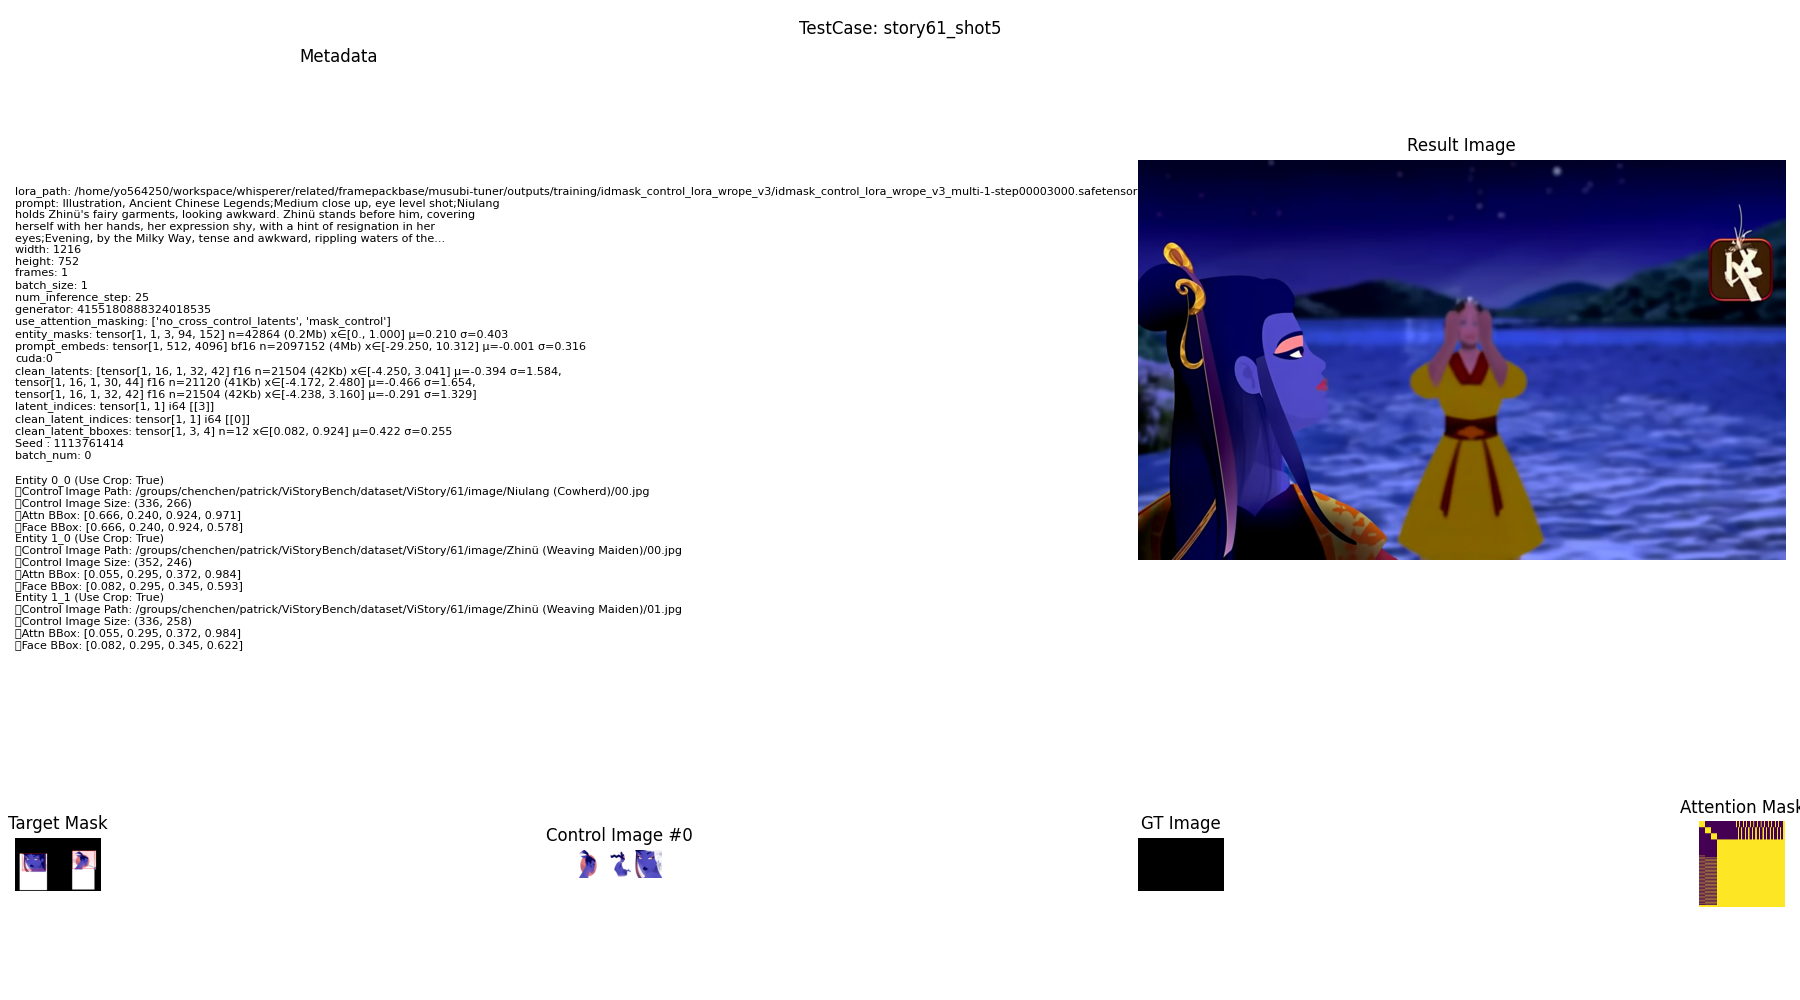

In [4]:
seed = np.random.randint(2**31) #1174730479, 2085107311
# seed = 1017027825

result_imgs, debug_imgs, debug_mask = framepack_model(
    prompt, panel_layout, characters_shot, width, height,
    c_width_given=320, seed=seed, crop_face_detect=True, use_rembg=True,
    cache_results=False, cache_layers=['transformer_blocks.2'], 
    use_attention_masking=['no_cross_control_latents', 'mask_control'], 
    control_indices=[0], latent_indices=[3], max_chara=5,
    debug_name=f"story{story_num}_shot{shot_num}"
)

debug_imgs[0]

# result_imgs[0].save(f"tmp/{story_num}/{shot_num-1}_0.png")
# debug_imgs[0].save(f"tmp/{story_num}/debug/{shot_num-1}_0.png")

In [ ]:
from musubi_tuner.utils.preproc_utils import postproc_imgs, get_text_preproc, get_all_control_kwargs
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan

# seed = np.random.randint(2**31)
seed = 1907324246
print(seed)
text_kwargs = get_text_preproc(prompt, 
    framepack_model.text_encoder1, framepack_model.text_encoder2, framepack_model.tokenizer1, framepack_model.tokenizer2, 
    entity_prompts=[], device=framepack_model.device)

control_kwargs, entity_masks, control_nps, debug_mask, print_res = get_all_control_kwargs(
    panel_layout, characters_shot, framepack_model.vae, width=width, height=height,
    crop_face_detect=True, use_rembg=True, 
    c_width_given=320, bbox_mode='provided_size_mid_x',
    control_indices=[0], latent_indices=[3], 
    max_chara_imgs=2, max_chara=5,
)
# print(print_res)
control_kwargs['clean_latent_bboxes'] = torch.tensor([[[0.,0.,1.,1.]]]).repeat(1, control_kwargs['clean_latent_bboxes'].shape[1], 1)
entity_masks = None

generator = torch.Generator(device="cpu")
generator.manual_seed(seed)
total_kwargs = {
    'prompt': prompt, 'sampler': 'unipc', 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
    'num_inference_step': 25, 'generator': generator, 'device': framepack_model.device, 'dtype': framepack_model.dtype,
    'cache_results': False, 'cache_layers': [],
    'use_attention_masking': [],
    'entity_masks': entity_masks,
}
# attn_cache.clear()
results = sample_hunyuan(transformer=framepack_model.model, **total_kwargs, **text_kwargs, **control_kwargs,)

result_img = Image.fromarray(postproc_imgs(results[0:1], framepack_model.vae)[0])
result_img

# Image.fromarray(np.sum(entitymask_nps, axis=0)>0).convert("RGB")

In [ ]:
block_id=f'transformer_blocks.2'
t_0=0
t_1=25
normalize=True

timesteps = sorted(list(attn_cache[block_id].keys()), reverse=False)
token_H, token_W = height // 16, width // 16
clean_latent_inds = attn_cache['attn_dict']['clean_latents']
noise_inds = attn_cache['attn_dict']['noise']

timesteps = sorted(list(attn_cache[block_id].keys()), reverse=False)
attention_probs = sum(attn_cache[block_id][timesteps[t]][:,noise_inds[0][0]:noise_inds[0][1],:] for t in range(t_0, t_1))
attention_map = rearrange(attention_probs, 'B (H W) D -> B H W D', H=token_H, W=token_W)
attention_map = attention_map.permute(0,3,1,2)
attention_map = attention_map[0,clean_latent_inds[0][0]:clean_latent_inds[-1][1],:,:].mean(axis=0)

if normalize:
    attention_map -= attention_map.min(1, keepdim=True)[0]
    attention_map /= attention_map.max(1, keepdim=True)[0]
print(attention_map.shape)

fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.imshow((attention_map.to(dtype=torch.float32).cpu().numpy()*255).astype(np.uint8), cmap='viridis')
ax.axis("off")
plt.show()

In [ ]:
results_dict_temp = {}
for i in range(9):
    seed = np.random.randint(2**31)
    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=400, seed=seed, crop_face_detect=False, use_rembg=True,
        cache_results=False, cache_layers=['transformer_blocks.2'], 
        use_attention_masking=['no_cross_control_latents'], 
        control_indices=[0], latent_indices=[3], max_chara=5,
        debug_name=f"story{story_num}_shot{shot_num}"
    )

    results_dict_temp[i] = {
        'seed' : seed,
        'result_img': result_imgs[0], 'debug_img': debug_imgs[0],
        'debug_mask': debug_mask,
    }

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, (key, value) in enumerate(results_dict_temp.items()):
    ax[i // 3, i % 3].imshow(value['result_img'])
    ax[i // 3, i % 3].set_title(f"Seed {value['seed']}")
    ax[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()

# results_dict_temp[8]['result_img'].save(Path("tmp") / f"{story_num}/{shot_num-1}_0.png")
# results_dict_temp[8]['debug_img'].save(Path("tmp") / f"{story_num}/debug/{shot_num-1}_0.png")

### DreamBench

In [5]:
import sys
sys.path.append("/groups/chenchen/patrick/dreambench_plus")
import pandas as pd
from dreambench_plus.dreambench_plus_dataset import DreamBenchPlus
from dreambench_plus.metrics.dino_score import DinoScore, Dinov2Score
from dreambench_plus.metrics.clip_score import CLIPScore

dreambench_plus = DreamBenchPlus(dir="/groups/chenchen/patrick/dreambench_plus/data")
dino_score = Dinov2Score(device='cuda')
clip_score = CLIPScore(device='cuda', use_safetensors=False)

from musubi_tuner.utils.preproc_utils import rmbg14_session

def rmbg_img(image_pil):
    image_pil = rmbg14_session(image_pil)
    new_image = Image.new("RGBA", image_pil.size, "WHITE")
    new_image.paste(image_pil, (0, 0), image_pil)
    image_pil = new_image.convert('RGB')
    return image_pil

Using cache found in /home/yo564250/.cache/torch/hub/facebookresearch_dino_main


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
list(Path("/groups/chenchen/patrick/dreambench_plus/").glob("*.csv"))

[Path('/groups/chenchen/patrick/dreambench_plus/whisperer_20251104_230855_seed42.csv'),
 Path('/groups/chenchen/patrick/dreambench_plus/dreamo_whisperer.csv'),
 Path('/groups/chenchen/patrick/dreambench_plus/whisperer_20251029_233840_seed42_copy.csv'),
 Path('/groups/chenchen/patrick/dreambench_plus/uno_20251102_092920.csv'),
 Path('/groups/chenchen/patrick/dreambench_plus/dreamo_20251031_083507.csv')]

In [10]:
save_dir = Path("/groups/chenchen/patrick/dreambench_plus/samples/whisperer_20251104_230855_seed42")

df1 = pd.read_csv("/groups/chenchen/patrick/dreambench_plus/whisperer_20251104_230855_seed42.csv")
df1.columns = ['Index', 'Name', 'dino_score', 'clipi_score', 'clipt_score']
print(df1[['dino_score', 'clipi_score', 'clipt_score']].mean())
df2 = pd.read_csv("/groups/chenchen/patrick/dreambench_plus/dreamo_20251031_083507.csv")
df2.columns = ['Index', 'Name', 'dino_score', 'clipi_score', 'clipt_score']
print(df2[['dino_score', 'clipi_score', 'clipt_score']].mean())

df = pd.merge(df1, df2, on=['Index', 'Name'], suffixes=('_whisperer', '_dreamo'))
# tmp = df.loc[(df.clipt_score_whisperer - df.clipt_score_dreamo < 0)].sort_values(by=['clipi_score_whisperer'])
tmp = df.loc[df.dino_score_whisperer < 30]
tmp = tmp.iloc[np.argsort(tmp.clipt_score_whisperer).values].reset_index(drop=True)
tmp

dino_score     60.436519
clipi_score    79.344181
clipt_score    32.379438
dtype: float64
dino_score     58.589897
clipi_score    79.345316
clipt_score    32.955865
dtype: float64


,Index,Name,dino_score_whisperer,clipi_score_whisperer,clipt_score_whisperer,dino_score_dreamo,clipi_score_dreamo,clipt_score_dreamo
0,448,live_subject_human_04_girl_7_0,12.320262,64.477325,22.628139,78.293549,82.054482,15.849948
1,443,live_subject_human_04_girl_2_0,13.158524,64.338913,23.026737,76.668800,84.091362,19.742943
2,424,live_subject_human_02_man_1_0,24.291553,74.998970,24.794977,9.926770,71.288040,30.967012
3,476,live_subject_human_07_man_8_0,27.859051,73.020966,26.130110,32.097034,80.012093,30.982231
4,471,live_subject_human_07_man_3_0,18.899292,73.222282,26.302927,9.324154,68.253265,26.701706
...,...,...,...,...,...,...,...,...
159,1237,style_07_impressionist_pointillism_4_0,28.031837,66.353737,39.165230,50.819702,77.719345,37.033348
160,1283,style_12_pixel_art_5_0,16.432575,62.713711,39.949535,11.188056,57.968117,38.488098
161,1177,style_00_pencil_sketch_7_0,12.874180,70.492867,39.980484,10.432144,71.743080,37.055195
162,1175,style_00_pencil_sketch_5_0,11.834665,67.843781,40.245903,13.035202,65.478775,32.687206


In [23]:
save_dir

Path('/groups/chenchen/patrick/dreambench_plus/samples/whisperer_20251104_230855_seed42')

live_subject_human_07_man_8_0
A depiction of a man shrinking to the size of an ant, exploring a world hidden within the grass
DINO Score: 27.859050750732425 CLIP-I Score: 73.02096557617188, CLIP-T Score: 26.130109786987305


  0%|          | 0/25 [00:00<?, ?it/s]

Trial 0 : Seed 892943441, DINO Score: 30.17795753479004 CLIP-I Score: 80.1641616821289, CLIP-T Score: 29.153812408447266


  0%|          | 0/25 [00:00<?, ?it/s]

Trial 1 : Seed 1386451293, DINO Score: 26.755708694458008 CLIP-I Score: 70.2460708618164, CLIP-T Score: 25.69035530090332


  0%|          | 0/25 [00:00<?, ?it/s]

Trial 2 : Seed 682436193, DINO Score: 10.311813354492188 CLIP-I Score: 68.89717864990234, CLIP-T Score: 29.70823860168457


  0%|          | 0/25 [00:00<?, ?it/s]

Trial 3 : Seed 1815959516, DINO Score: 41.26449966430664 CLIP-I Score: 81.53995513916016, CLIP-T Score: 28.99263572692871


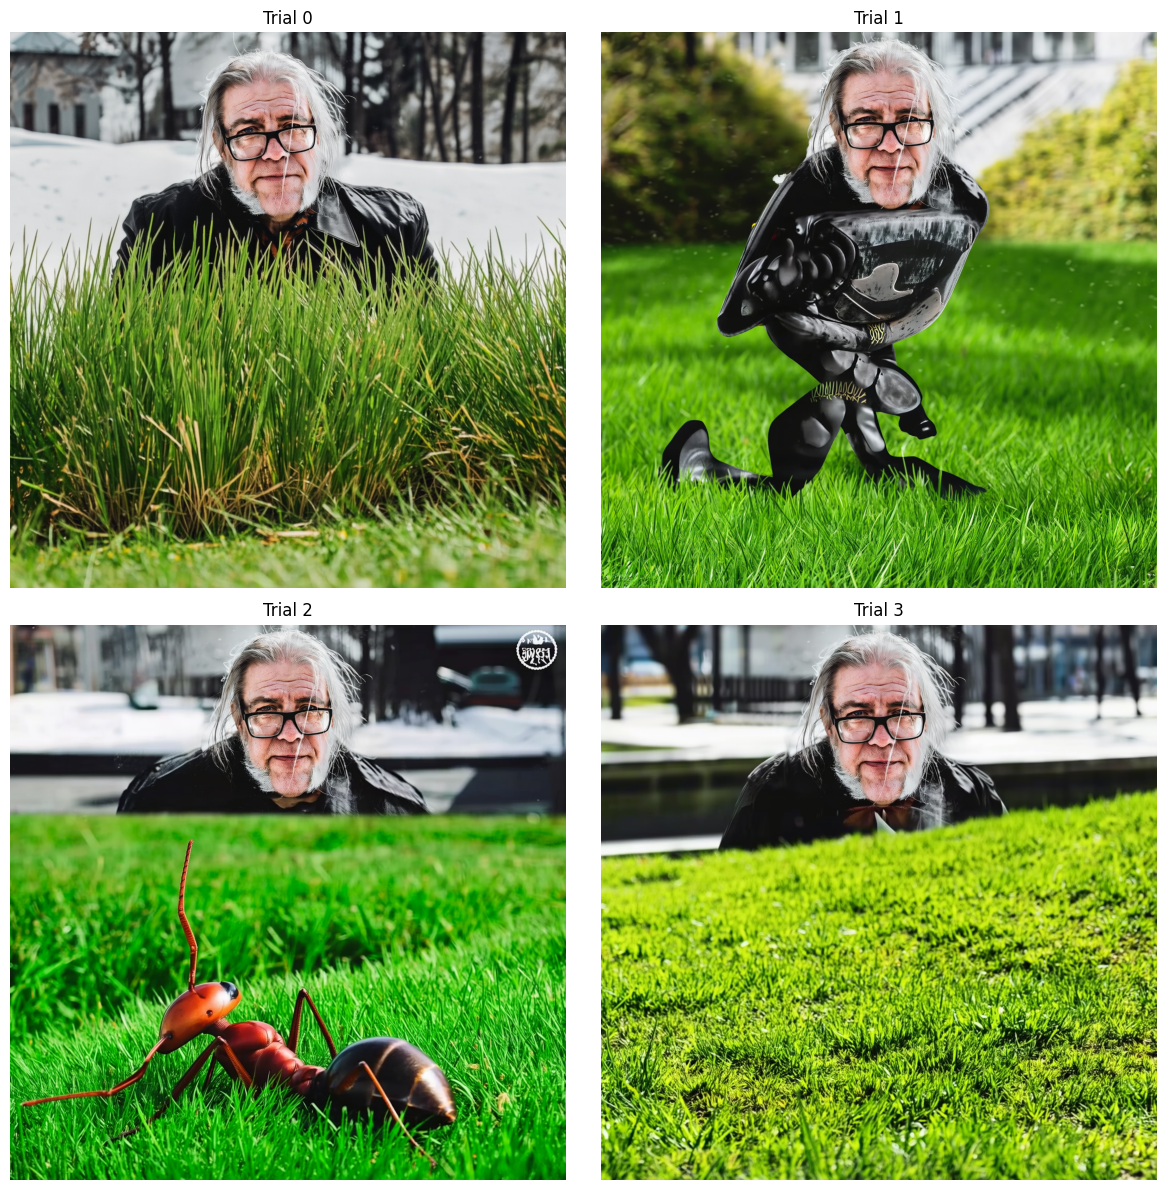

In [21]:
row = tmp.iloc[3]
sample = dreambench_plus[row.Index // 9]
caption_ind = row.Index % 9
width, height = 1024, 1024

prompt = sample.captions[caption_ind]
c_width = 320

panel_layout = {0: {'bbox': [0.2, 0.0, 0.8, 1.0], 'body': []}}
characters_shot = {0 : {'images' : [sample.image_path]}}
print(row.Name)
print(prompt)
print(f"DINO Score: {row.dino_score_whisperer} CLIP-I Score: {row.clipi_score_whisperer}, CLIP-T Score: {row.clipt_score_whisperer}")

trials = 4
final_imgs = []
for i in range(trials):
    seed = np.random.randint(2**31) 
    result_img, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=c_width, seed=seed, crop_face_detect=False, use_rembg=False,
        cache_results=False, cache_layers=['transformer_blocks.2'], 
        use_attention_masking=['no_cross_control_latents'], 
        control_indices=[0], latent_indices=[3],
        debug_name=f"{sample.collection_id}-{caption_ind}"
    )

    source_img = Image.open(sample.image_path)
    target_img = result_img[0]
    dino_score_eval = dino_score.dino_score(source_img, target_img)[0]
    clipi_score_eval = clip_score.clipi_score(source_img, target_img)[0]
    clipt_score_eval = clip_score.clipt_score(prompt, target_img)[0]
    print(f"Trial {i} : Seed {seed}, DINO Score: {dino_score_eval} CLIP-I Score: {clipi_score_eval}, CLIP-T Score: {clipt_score_eval}")
    final_imgs.append(result_img[0])

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
for i in range(trials):
    ax[i // 2, i % 2].imshow(final_imgs[i])
    ax[i // 2, i % 2].set_title(f"Trial {i}")
    ax[i // 2, i % 2].axis('off')
plt.tight_layout()
plt.show()
# result_imgs[0].convert("RGB").save(save_dir / f"tgt_img/{sample.collection_id}/{caption_ind}_0.jpg")

# seed = np.random.randint(2**31) 
# result_imgs, debug_imgs, debug_mask = framepack_model(
#     prompt, panel_layout, characters_shot, width, height,
#     c_width_given=c_width, seed=seed, crop_face_detect=False, use_rembg=False,
#     cache_results=False, cache_layers=['transformer_blocks.2'], 
#     use_attention_masking=['no_cross_control_latents'], 
#     control_indices=[0], latent_indices=[3],
#     debug_name=f"{sample.collection_id}-{caption_ind}"
# )


# print(f"Trial {0}: Seed {seed}, DINO Score: {dino_score_eval} vs {row.dino_score}, CLIP-I Score: {clipi_score_eval} vs {row.clipi_score}, CLIP-T Score: {clipt_score_eval} vs {row.clipt_score}")

In [22]:
final_imgs[3].convert("RGB").save(save_dir / f"tgt_img/{sample.collection_id}/{caption_ind}_0.jpg")

In [ ]:
outputs_root = Path("/groups/chenchen/patrick/ViStoryBench/outputs/")
story_num = 17
shutil.copytree(
    f"/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/practice/tmp/{story_num}", 
    outputs_root / f"whisperer/v3_3_step6000/en/20251028_232847_v2/{story_num}", 
    dirs_exist_ok=True
)
# shutil.copytree(
#     "/lustre/fs1/groups/chenchen/patrick/ViStoryBench/outputs/whisperer/v3_3_step6000/en/20251028_232847", 
#    "/lustre/fs1/groups/chenchen/patrick/ViStoryBench/outputs/whisperer/v3_3_step6000/en/20251028_232847_v2",
#     dirs_exist_ok=True
# )

In [ ]:
import time

trials = 10
trials_time = []

idx = 44
sample = dreambench_plus[idx // 9]
caption_ind = idx % 9
width, height = 1024, 1024

prompt = sample.captions[caption_ind]
c_width = 512
panel_layout = {0: {'bbox': [0.1, 0.1, 0.9, 0.9], 'body': []}}
characters_shot = {0 : {'images' : [sample.image_path]}}

for _ in range(trials):
    start_time = time.time()
    
    seed = np.random.randint(2**31)
    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=c_width, seed=seed, crop_face_detect=False, use_rembg=False,
        cache_results=False, cache_layers=['transformer_blocks.2'], 
        use_attention_masking=['no_cross_control_latents'], 
        control_indices=[0], latent_indices=[3],
        debug_name=f"{sample.collection_id}-{caption_ind}"
    )

    end_time = time.time()
    trials_time.append(end_time - start_time)

print(f"Avg inference time over {trials} trials: {np.mean(trials_time):.2f} sec")